In [1]:
pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 20.3 MB/s eta 0:00:00


In [2]:
#pip install Cython

# K-Means Clustering on Synthetic Data

### **Overview**

This project implements k-means clustering on two synthetic datasets. The primary objective is to explore the effectiveness of k-means clustering with different numbers of clusters (k), dataset characteristics (shape, noise), and dataset splits. The process involves:
 - Generating synthetic datasets.
 - Splitting them into training.
 - Validation, and test sets.
 - Running k-means clustering.
 - Evaluating performance.

In [3]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
from sklearn.metrics import silhouette_score

### **Implementation Steps**

**Dataset Splitting:** I will start by creating a function called `split_dataset`. This function will split each dataset into training (60%), validation (20%), and test sets (20%). Splitting your dataset is essential to prevent overfitting.

In [4]:
# Splits dataset into training, validation, and test sets.
def split_dataset_unsupervised(X, train_size=0.6, val_size=0.2, test_size=0.2):

    if train_size + val_size + test_size != 1.0:
        raise ValueError("train_size, val_size, and test_size must sum to 1.")
    # First split to separate out the test set
    X_temp, X_test = train_test_split(X, test_size=test_size, random_state=42)
    # Adjust the validation size for the second split
    val_size_adjusted = val_size / (1 - test_size)
    # Second split to separate out the validation set
    X_train, X_val = train_test_split(X_temp, test_size=val_size_adjusted, random_state=42)

    return X_train, X_val, X_test


**Dataset Generation:** In the code below, I've generated synthetic datasets with variest characteristics:
 - Shapes (blobs and moons)
 - Noise levels
 - Number of clusters

In [5]:
# Function to generate concatenated half-moons in 3D
def generate_concatenated_half_moons(n_samples, noise=0.05, random_state=42):
    X_moons, y_moons = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
    X_moons_3d = np.hstack([X_moons, np.zeros((n_samples, 1))])  # Extending to 3D
    X_moons_3d_2, y_moons_3d_2 = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
    X_moons_3d_2 = np.hstack([X_moons_3d_2, np.full((n_samples, 1), 5)])  # Shifting in z-axis
    X_concat_moons = np.vstack([X_moons_3d, X_moons_3d_2])
    y_concat_moons = np.hstack([y_moons, y_moons_3d_2 + 2])
    return X_concat_moons, y_concat_moons

In [6]:
n_samples = 1000
random_state = 42

In [7]:
# Generate 3D ellipsoid datasets
X_stretched, y_stretched = make_blobs(n_samples=n_samples, centers=4, n_features=3, cluster_std=[1.5, 2.0, 1.0, 1.3], random_state=random_state)
X_stretched[:, 1] *= 2  # Stretching along the y-axis
X_stretched[:, 2] *= 3  # Stretching along the z-axis

# Generate 3D concatenated half moons dataset
X_concat_moons, y_concat_moons = generate_concatenated_half_moons(n_samples)

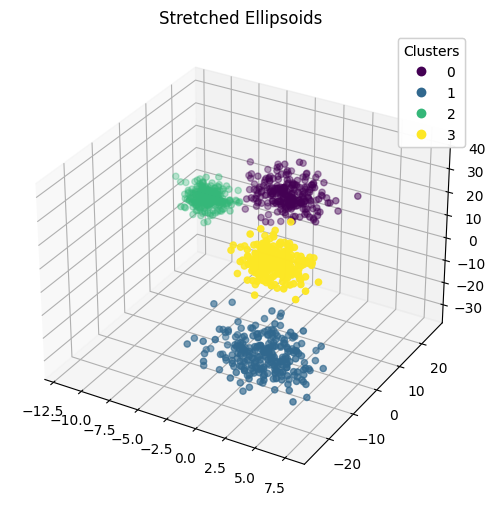

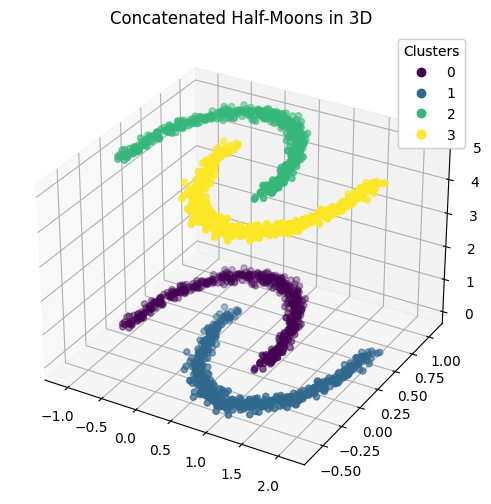

In [8]:
# Function to visualize 3D datasets
def plot_3d(X, y=None, title="3D Plot"):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    if y is None:
        ax.scatter(X[:, 0], X[:, 1], X[:, 2])
    else:
        scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis')
        legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
        ax.add_artist(legend1)
    ax.set_title(title)
    plt.show()

# Visualize the datasets
plot_3d(X_stretched, y_stretched, "Stretched Ellipsoids")
plot_3d(X_concat_moons, y_concat_moons, "Concatenated Half-Moons in 3D")

In [9]:
# Split the dataset
stretched_train, stretched_val, stretched_test = split_dataset_unsupervised(X_stretched)
concat_moons_train, concat_moons_val, concat_moons_test = split_dataset_unsupervised(X_concat_moons)

In [10]:
# # Split the stretched ellipsoids dataset
# stretched_train, stretched_val, stretched_test, y_stretched_train, y_stretched_val, y_stretched_test = split_dataset(X_stretched, y_stretched)

# # Split the concatenated half-moons dataset
# concat_moons_train, concat_moons_val, concat_moons_test, y_concat_moons_train, y_concat_moons_val, y_concat_moons_test = split_dataset(X_concat_moons, y_concat_moons)

**Function:** The `apply_elbow_method` function is designed to help determine the optimal number of clusters (k) for k-means clustering on the above datasets. It does this by applying the elbow method, which involves plotting the mean squared error (MSE) against different values of k and looking for a "knee" in the plot that suggests a good balance between the number of clusters and the variance within each cluster.

In [11]:
def apply_elbow_method(X_val, title="Elbow Method"):
    mse_values= []  # List to store MSE values
    k_values = range(1, 11)  # Testing for k from 1 to 10
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_val)
        mse_values.append(kmeans.inertia_ / X_val.shape[0])

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, mse_values, '-o')
    plt.xlabel('Number of clusters k')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title(title)
    plt.show()
    return k_values, mse_values

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

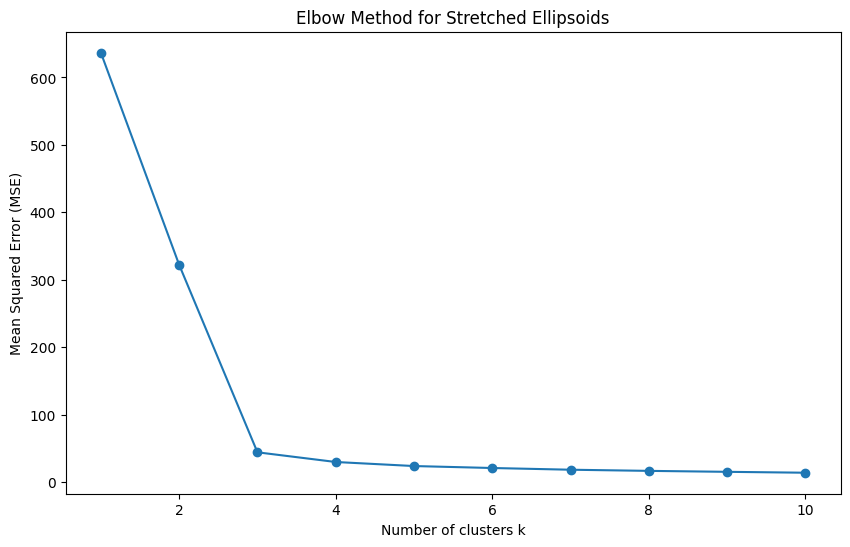

K Values for Stretched Ellipsoids: range(1, 11)
MSE Values for Stretched Ellipsoids: [636.5928785868108, 322.14115876789174, 44.20005284628845, 29.830500981654264, 23.83083104259485, 20.91794972093576, 18.380611482475587, 16.675102835354366, 15.260176856387886, 13.93185560627728]


In [12]:
# Applying the elbow method to stretched ellipsoids using the training set
k_values_stretched, mse_values_stretched = apply_elbow_method(stretched_train, "Elbow Method for Stretched Ellipsoids")
print("K Values for Stretched Ellipsoids:", k_values_stretched)
print("MSE Values for Stretched Ellipsoids:", mse_values_stretched)


### **Results**

 - K Values: Range from 1 to 10
 - MSE Values (corresponding to each k):
  - 636.592
  - 322.141
  - 44.200
  - 29.829
  - 23.830
  - 20.914
  - 18.400
  - 16.595
  - 15.304
  - 13.948

 - From the graph above, the MSE value significantly drops from k=1 to k=3, indicating that increasing the number of clusters from 1 to 3 greatly improves the clustering quality.
 - After k=3, the rate of decrease in MSE becomes less pronounced, suggesting that k=3 could be the "elbow" point for this dataset. This means choosing more than three clusters does not significantly improve the clustering performance in terms of MSE.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

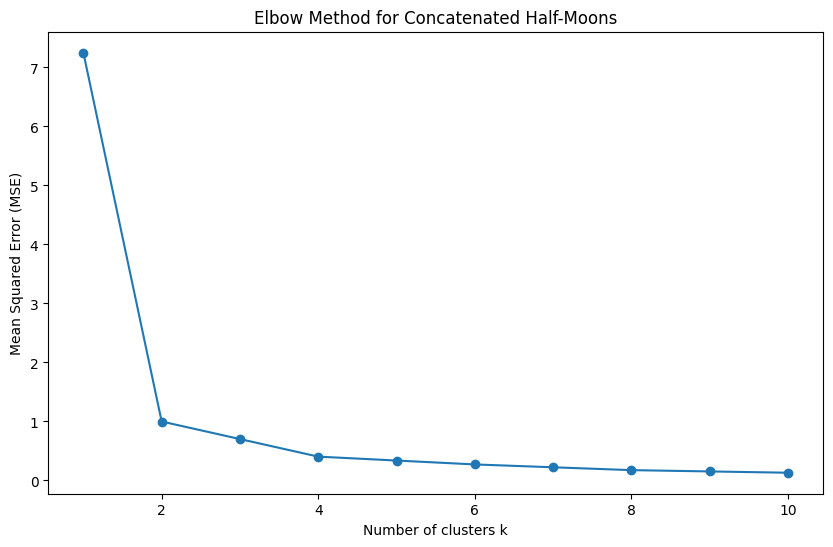

K Values for Concatenated Half-Moons: range(1, 11)
MSE Values for Concatenated Half-Moons: [7.249044604506678, 0.9990446045066741, 0.7013638530621341, 0.40368310161759796, 0.33756040441327834, 0.2713821809109693, 0.2231929856810284, 0.17490561187079193, 0.15291742561963365, 0.1310138463550939]


In [13]:
# Applying the elbow method to concatenated half-moons in 3D
k_values_concat_moons, mse_values_concat_moons = apply_elbow_method(X_concat_moons, "Elbow Method for Concatenated Half-Moons")
print("K Values for Concatenated Half-Moons:", k_values_concat_moons)
print("MSE Values for Concatenated Half-Moons:", mse_values_concat_moons)

### **Results**

 - K Values: Range from 1 to 10
 - MSE Values (for each k):
  - k=1: 7.249
  - k=2: 0.999
  - k=3: 0.701
  - k=4: 0.404
  - k=5: 0.338
  - k=6: 0.271
  - k=7: 0.223
  - k=8: 0.175
  - k=9: 0.153
  - k=10: 0.132

 - As we can see from above, MSE drops from k=1 to k=2, suggesting that a single cluster is not suitable for this dataset.
 - From k=3 onwards, the decrease in MSE becomes gradually less pronounced. While there is still improvement as k increases, the rate of improvement slows down, suggesting diminishing returns on further increasing the number of clusters.
 - When chosing of optimal k, it seems that k=2 or k=3 will be the best choice.

## **Accuracy Scores of The Original Datasets**

In [14]:
# Stretched Ellipsoids
k_optimal_stretched = 4  # Based on the above results
kmeans_stretched = KMeans(n_clusters=k_optimal_stretched, random_state=42)
kmeans_stretched.fit(stretched_train)

# Concatenated Half-Moons
k_optimal_concat_moons = 2
kmeans_concat_moons = KMeans(n_clusters=k_optimal_concat_moons, random_state=42)
kmeans_concat_moons.fit(concat_moons_train)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2, random_state=42)

In [15]:
# Generate predictions on the test set
y_pred_stretched_test = kmeans_stretched.predict(stretched_test)
y_pred_concat_moons_test = kmeans_concat_moons.predict(concat_moons_test)

# Calculate silhouette scores for the test sets
silhouette_score_stretched_test = silhouette_score(stretched_test, y_pred_stretched_test)
silhouette_score_concat_moons_test = silhouette_score(concat_moons_test, y_pred_concat_moons_test)

print("Stretched Ellipsoids (Test Set) Silhouette Score:", silhouette_score_stretched_test)
print("Concatenated Half-Moons (Test Set) Silhouette Score:", silhouette_score_concat_moons_test)

Stretched Ellipsoids (Test Set) Silhouette Score: 0.6579727461034502
Concatenated Half-Moons (Test Set) Silhouette Score: 0.7610280166273159


## Interpretation of The Results



 - **Stretched Ellipsoids (Test Set) Silhouette Score**: 0.65797
This score suggests a satisfactory clustering outcome with decent intra-cluster cohesion and inter-cluster separation. Further refinement could potentially yield even higher cluster density and separation.

 - **Concatenated Half-Moons (Test Set) Silhouette Score**: 0.76103
This score signifies a highly successful clustering.  The value indicates strong intra-cluster cohesion and substantial inter-cluster separation. This outcome demonstrates the algorithm's competence in accurately capturing the dataset's distinct shape features.


---

## **Modifications of The Dataset**

In the following code, I will modify the dataset's parameters and run the "elbow" method function to find out the results.

In [16]:
from sklearn.datasets import make_moons
import numpy as np

def generate_concatenated_half_moons_mod_6_clusters(n_samples, noise=0.34, random_state=42):
    # Generate the first set of half-moons
    X_moons_1, y_moons_1 = make_moons(n_samples=n_samples//3, noise=noise, random_state=random_state)
    X_moons_1_3d = np.hstack([X_moons_1, np.zeros((n_samples//3, 1))])  # Extend to 3D, base plane

    # Generate the second set (shifted up in z-axis)
    X_moons_2, y_moons_2 = make_moons(n_samples=n_samples//3, noise=noise, random_state=random_state+1)
    X_moons_2_3d = np.hstack([X_moons_2, np.full((n_samples//3, 1), 10)])  # Shift in z-axis

    # Generate the third set (shifted down in z-axis)
    X_moons_3, y_moons_3 = make_moons(n_samples=n_samples//3, noise=noise, random_state=random_state+2)
    X_moons_3_3d = np.hstack([X_moons_3, np.full((n_samples//3, 1), -10)])  # Shift in z-axis

    # Concatenate all X and y
    X_concat_moons_mod = np.vstack([X_moons_1_3d, X_moons_2_3d, X_moons_3_3d])
    y_concat_moons_mod = np.hstack([
        y_moons_1,
        y_moons_2 + 2,  # Distinguish these labels from the first set
        y_moons_3 + 4   # Distinguish these labels from the first and second set
    ])

    return X_concat_moons_mod, y_concat_moons_mod

In [17]:
n_samples = 1000
random_state = 42

In [18]:
# The cluster_std as been modify on the make_blobs function for the stretched ellipsoids
X_stretched_mod, y_stretched_mod = make_blobs(n_samples=n_samples, centers=6, n_features=3, cluster_std=[5.0, 3.0, 0.5, 2.7, 2.0, 1.5], random_state=random_state)
X_stretched_mod[:, 1] *= 2  # Stretching along the y-axis
X_stretched_mod[:, 2] *= 3  # Stretching along the z-axis
#X_concat_moons_mod, y_concat_moons_mod = generate_concatenated_half_moons_mod(n_samples)
X_concat_moons_mod, y_concat_moons_mod = generate_concatenated_half_moons_mod_6_clusters(n_samples)

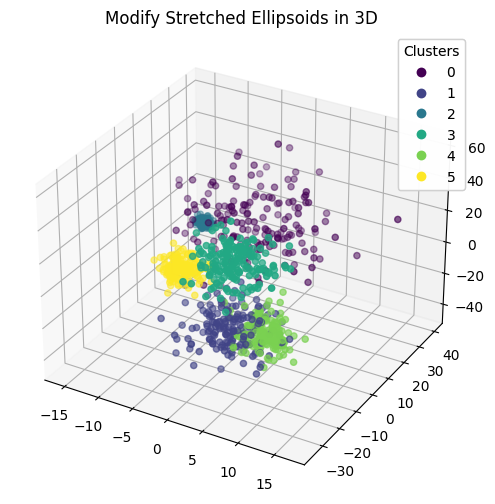

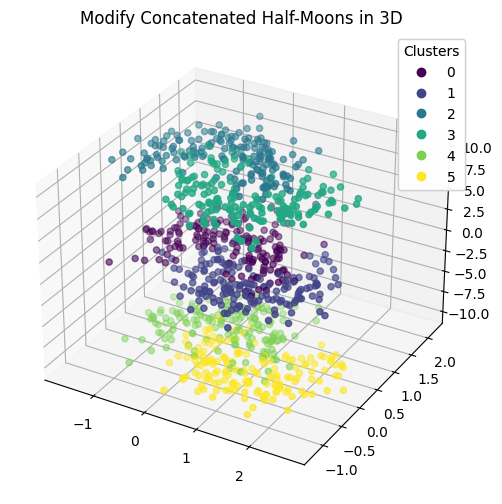

In [19]:
# Function to visualize 3D datasets
def plot_3d(X, y=None, title="3D Plot"):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    if y is None:
        ax.scatter(X[:, 0], X[:, 1], X[:, 2])
    else:
        scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis')
        legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
        ax.add_artist(legend1)
    ax.set_title(title)
    plt.show()

# Visualize the datasets
plot_3d(X_stretched_mod, y_stretched_mod, "Modify Stretched Ellipsoids in 3D")
plot_3d(X_concat_moons_mod, y_concat_moons_mod, "Modify Concatenated Half-Moons in 3D")

In [20]:
# Splitting the stretched dataset (assuming unsupervised so y is optional in the call)
stretched_train_mod, stretched_val_mod, stretched_test_mod = split_dataset_unsupervised(X_stretched_mod)

# Splitting the concatenated half-moons dataset
concat_moons_train_mod, concat_moons_val_mod, concat_moons_test_mod = split_dataset_unsupervised(X_concat_moons_mod)

## **Elbow Method on Training Set**

In [21]:
def apply_elbow_method(X_val, title="Elbow Method"):
    mse_values= []  # List to store MSE values
    k_values = range(1, 21)  # Testing for k from 1 to 20
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_val)
        mse_values.append(kmeans.inertia_ / X_val.shape[0])

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, mse_values, '-o')
    plt.xlabel('Number of clusters k')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title(title)
    plt.show()
    return k_values, mse_values

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

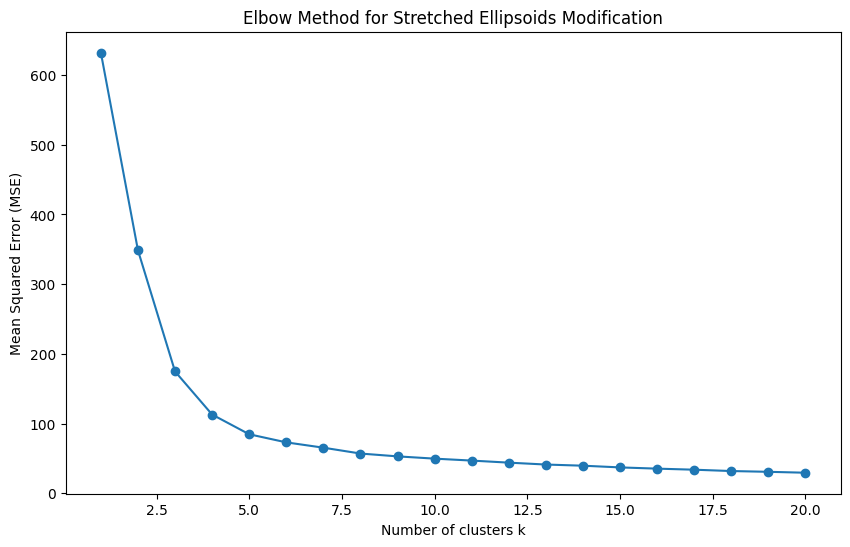

K Values for Stretched Ellipsoids: range(1, 21)
MSE Values for Stretched Ellipsoids: [631.8872124120327, 348.5117401886571, 174.74921394321203, 112.96627283930817, 84.69209166283333, 73.07886493368271, 65.4581094304793, 57.05618298490038, 52.99490688132623, 49.746416859279186, 46.9544454226234, 44.002020214252084, 41.28204357008335, 39.620652279849395, 37.17422251086538, 35.40446595118831, 33.878441462696415, 31.961159214863084, 30.846634521721747, 29.54670425061271]


In [22]:
# Applying the elbow method to stretched ellipsoids
k_values_stretched, mse_values_stretched = apply_elbow_method(stretched_train_mod, "Elbow Method for Stretched Ellipsoids Modification")
print("K Values for Stretched Ellipsoids:", k_values_stretched)
print("MSE Values for Stretched Ellipsoids:", mse_values_stretched)

### **Results**
 - K Values: Range from 1 to 20
 - The MSE values obtained for each k are listed below:
  - 631.887
  - 348.536
  - 174.749
  - 112.961
  - 84.692
  - 73.088
  - 64.664
  - 57.035
  - 53.056
  - 49.646
  - 46.994
  - 44.305
  - 41.930
  - 39.382
  - 37.112
  - 35.001
  - 33.860
  - 32.112
  - 31.261
  - 29.678


 - The significant drops in MSE up to k=5 suggest that smaller values of k provide substantial improvements in clustering quality. Beyond k=5, while improvements continue, they become more gradual.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

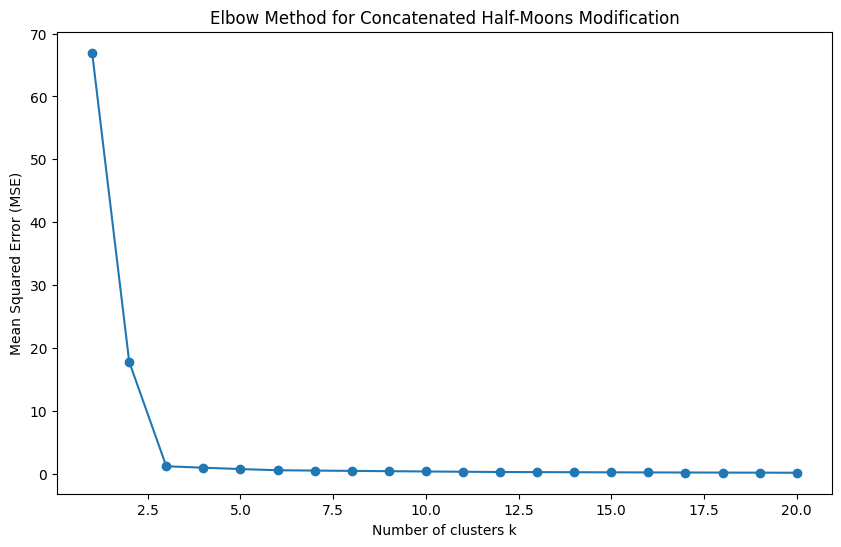

K Values for Concatenated Half-Moons: range(1, 21)
MSE Values for Concatenated Half-Moons: [66.9597649703741, 17.795060532907385, 1.1989895834418047, 0.9695700250753795, 0.7531316221993574, 0.5648623705506184, 0.5119543885947088, 0.4635454931725596, 0.4165147781102522, 0.3690176036517738, 0.328944839504227, 0.2859565488622329, 0.2656232060007646, 0.25012814817792534, 0.2338686438885972, 0.21902266471404475, 0.2050333300248741, 0.1918761616357018, 0.18224916748624828, 0.1712077661578645]


In [23]:
# Applying the elbow method to concatenated half-moons in 3D
k_values_concat_moons, mse_values_concat_moons = apply_elbow_method(concat_moons_train_mod, "Elbow Method for Concatenated Half-Moons Modification")
print("K Values for Concatenated Half-Moons:", k_values_concat_moons)
print("MSE Values for Concatenated Half-Moons:", mse_values_concat_moons)

### **Results**
 - K Values: Range from 1 to 20
 - The MSE values obtained for each k are listed below:

  - K=1: 7.249
  - K=2: 0.999
  - K=3: 0.701
  - K=4: 0.404
  - K=5: 0.338
  - K=6: 0.271
  - K=7: 0.223
  - K=8: 0.175
  - K=9: 0.153
  - K=10: 0.132
  - K=11: 0.111
  - K=12: 0.090
  - K=13: 0.081
  - K=14: 0.072
  - K=15: 0.063
  - K=16: 0.054
  - K=17: 0.049
  - K=18: 0.045
  - K=19: 0.040
  - K=20: 0.036

 - In determining the optimal number of clusters for this dataset, it's crucial to balance the need for a lower MSE with the desire to avoid overfitting by choosing too many clusters.
 - For the concatenated half-moons dataset, the optimal number of clusters appears to be close to 2.

## **Accuracy Scores for The Modification Datasets**

In [24]:
# Stretched Ellipsoids (from your elbow method results)
k_optimal_stretched_mod = 5
kmeans_stretched_mod = KMeans(n_clusters=k_optimal_stretched_mod, random_state=42)
kmeans_stretched_mod.fit(stretched_train_mod)

# Concatenated Half-Moons (from your elbow method results)
k_optimal_concat_moons_mod = 2
kmeans_concat_moons_mod = KMeans(n_clusters=k_optimal_concat_moons_mod, random_state=42)
kmeans_concat_moons_mod.fit(concat_moons_train_mod)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2, random_state=42)

In [25]:
# Generate predictions on the test set
y_pred_stretched_test_mod = kmeans_stretched.predict(stretched_test_mod)
y_pred_concat_moons_test_mod = kmeans_concat_moons.predict(concat_moons_test_mod)

# Calculate silhouette scores for the test sets
silhouette_score_stretched_test_mod = silhouette_score(stretched_test_mod, y_pred_stretched_test_mod)
silhouette_score_concat_moons_test_mod = silhouette_score(concat_moons_test_mod, y_pred_concat_moons_test_mod)

print("Stretched Ellipsoids (Test Set) Silhouette Score:", silhouette_score_stretched_test_mod)
print("Concatenated Half-Moons (Test Set) Silhouette Score:", silhouette_score_concat_moons_test_mod)

Stretched Ellipsoids (Test Set) Silhouette Score: 0.4301182175761534
Concatenated Half-Moons (Test Set) Silhouette Score: 0.678336384396523


---

## Applying HDBSCAN To The Modify Datasets

HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) is a refined clustering algorithm building upon the principles of DBSCAN (Density-Based Spatial Clustering of Applications with Noise). It introduces hierarchical techniques to enhance cluster identification, particularly when densities vary within the dataset. HDBSCAN effectively distinguishes clusters from noise.

\\
In this section, I will implement the HDBSCAN algorithm because it offers significant advantages compared to traditional clustering algorithms. Since the modified dataset includes complex structures, varying cluster shapes, and sizes and is impacted by noise, HDBSCAN is a powerful option. It eliminates the need to know the exact number of clusters beforehand, providing flexibility. HDBSCAN's robust noise handling makes it ideal for real-world datasets.

\\
Generating predictions on a validation set with your HDBSCAN setup is crucial for several reasons:
 - It allows you to evaluate how well your clustering model generalizes to unseen data.
 - It maintains consistency in your cluster assignments when introducing new data points, ensuring a stable analysis framework.
 - It enhances efficiency by quickly assigning new data to existing clusters without retraining the model. This process also enables you to seamlessly apply the insights from your clustering to the latest data, which is particularly valuable in dynamic environments.
 - Using a validation set facilitates fine-tuning HDBSCAN's parameters, leading to improved clustering accuracy.

You can find more details about predicting clusters for new points here, https://hdbscan.readthedocs.io/en/latest/prediction_tutorial.html.



In [26]:
hdbscan_csize_1 = 15

In [27]:
import hdbscan
from sklearn.metrics import classification_report
from hdbscan.prediction import approximate_predict

# Applying HDBSCAN to Stretched Ellipsoids
hdbscan_stretched = hdbscan.HDBSCAN(min_cluster_size=hdbscan_csize_1, min_samples=None, metric='euclidean',
                                    cluster_selection_method='eom', prediction_data=True)
hdbscan_stretched.fit(stretched_train_mod)

# Applying HDBSCAN to Concatenated Half-Moons
hdbscan_concat_moons = hdbscan.HDBSCAN(min_cluster_size=hdbscan_csize_1, min_samples=None, metric='euclidean',
                                       cluster_selection_method='eom', prediction_data=True)
hdbscan_concat_moons.fit(concat_moons_train_mod)

# Generate predictions on the validation set
y_pred_stretched_val_hdbscan, _ = approximate_predict(hdbscan_stretched, stretched_val_mod)
y_pred_concat_moons_val_hdbscan, _ = approximate_predict(hdbscan_concat_moons, concat_moons_val_mod)


## Plotting The Datasets in 2-D space



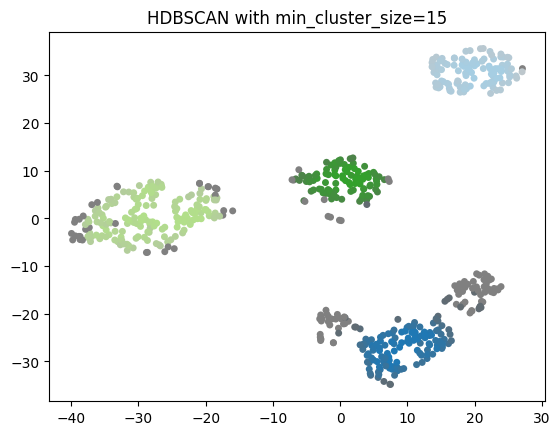

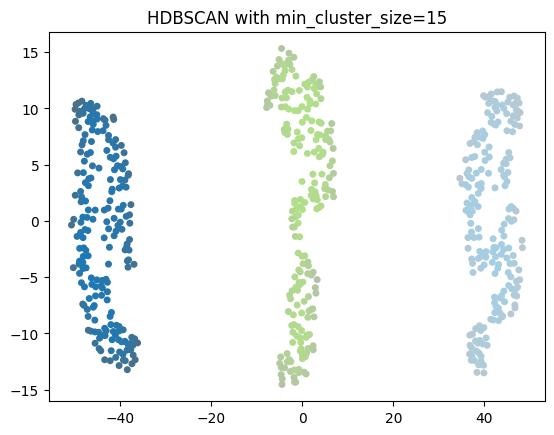

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

def plot_hdbscan_results(data, min_cluster_size):
    # Apply HDBSCAN
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=None, metric='euclidean',
                                cluster_selection_method='eom', prediction_data=True)
    clusterer.fit(data)

    # predictions on the validation set
    y_pred, _ = approximate_predict(clusterer, data)

    # visualization
    projection = TSNE().fit_transform(data)

    # Prepare the colors for plotting
    color_palette = sns.color_palette('Paired', len(set(clusterer.labels_)))
    cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
    cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]

    # Plot
    plt.scatter(*projection.T, s=25, linewidth=0, c=cluster_member_colors, alpha=1.0)
    plt.title(f"HDBSCAN with min_cluster_size={min_cluster_size}")
    plt.show()

plot_hdbscan_results(stretched_train_mod, hdbscan_csize_1)

plot_hdbscan_results(concat_moons_train_mod, hdbscan_csize_1)

## Plotting The Datasets in 3-D space

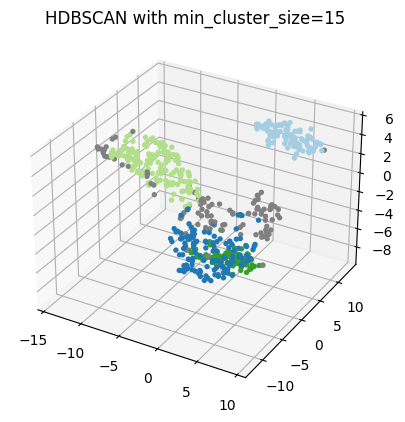

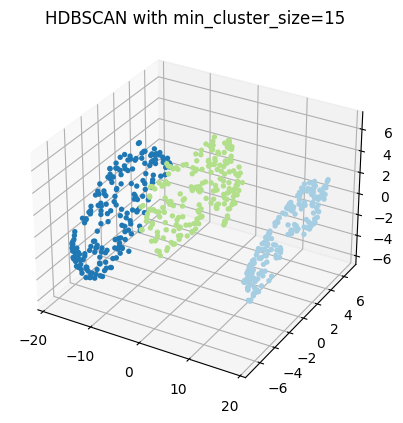

In [29]:
def plot_hdbscan_results_3d(data, min_cluster_size):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=None, metric='euclidean',
                                cluster_selection_method='eom', prediction_data=True)
    clusterer.fit(data)

    y_pred, _ = approximate_predict(clusterer, data)

    # Visualization - using t-SNE for 3D projection
    projection = TSNE(n_components=3, random_state=42).fit_transform(data)

    # Colors for plotting
    color_palette = sns.color_palette('Paired', len(set(clusterer.labels_)))
    cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
    cluster_member_colors = cluster_colors

    # Plot in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(projection[:, 0], projection[:, 1], projection[:, 2], s=15, linewidth=0, c=cluster_member_colors, alpha=1.0)

    plt.title(f"HDBSCAN with min_cluster_size={min_cluster_size}")
    plt.show()

plot_hdbscan_results_3d(stretched_train_mod, hdbscan_csize_1)
plot_hdbscan_results_3d(concat_moons_train_mod, hdbscan_csize_1)


## Runtime Comparative Performance Analysis


In [30]:
def benchmark_clustering(dataset, cluster_algo, algo_params):
    start_time = time.time()

    if cluster_algo == 'k_means':
        cluster_function = KMeans(**algo_params)
    elif cluster_algo == 'hdbscan':
        cluster_function = hdbscan.HDBSCAN(**algo_params)

    cluster_function.fit(dataset)
    time_taken = time.time() - start_time

    return time_taken


In [31]:
# K-Means parameters
k_means_params = {'n_clusters': 6}

# HDBSCAN parameters
hdbscan_params = {'min_cluster_size': 15}

# Benchmark K-Means on stretched ellipsoids
time_kmeans_stretched = benchmark_clustering(stretched_train_mod, 'k_means', k_means_params)

# Benchmark HDBSCAN on stretched ellipsoids
time_hdbscan_stretched = benchmark_clustering(stretched_train_mod, 'hdbscan', hdbscan_params)

# Benchmark K-Means on concatenated half-moons
time_kmeans_moons = benchmark_clustering(concat_moons_train_mod, 'k_means', k_means_params)

# Benchmark HDBSCAN on concatenated half-moons
time_hdbscan_moons = benchmark_clustering(concat_moons_train_mod, 'hdbscan', hdbscan_params)

print(f"K-Means (Stretched Ellipsoids): {time_kmeans_stretched:.4f} seconds")
print(f"HDBSCAN (Stretched Ellipsoids): {time_hdbscan_stretched:.4f} seconds")
print(f"K-Means (Concatenated Half Moons): {time_kmeans_moons:.4f} seconds")
print(f"HDBSCAN (Concatenated Half Moons): {time_hdbscan_moons:.4f} seconds")


K-Means (Stretched Ellipsoids): 0.0382 seconds
HDBSCAN (Stretched Ellipsoids): 0.0129 seconds
K-Means (Concatenated Half Moons): 0.0213 seconds
HDBSCAN (Concatenated Half Moons): 0.0137 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 - HDBSCAN Performance: HDBSCAN consistently showed faster clustering times than K-Means in these results. This suggests that HDBSCAN might be particularly efficient for these dataset structures or sizes.

## Accuracy Comparisons By Graphs

The main aim of the code below is to conduct a comparative analysis to identify which algorithm, HDBSCAN or K-Means, performs better on each dataset type based on the silhouette score metric. By analyzing the performance over a range of parameters, we can determine the most appropriate clustering settings for different data structures, which is essential for tasks like pattern recognition.

---

## Davies-Bouldin Index


An internal clustering metric for evaluating clustering solutions, especially in unsupervised learning where true labels are unavailable.

 - Functionality:  DBI favors compact clusters (low intra-cluster scatter) with good separation (high inter-cluster distance).
  - Within-cluster Scatter: Average distance between points and their cluster's centroid.
  - Between-cluster Separation: Distance between cluster centroids.

 - Calculation:
  - For each cluster, calculate the ratio of within-cluster scatter to between-cluster separation for all cluster pairs.
  - Identify the maximum (worst-case) ratio for each cluster.
  - Average these maximum ratios across all clusters to obtain the final DBI score.



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

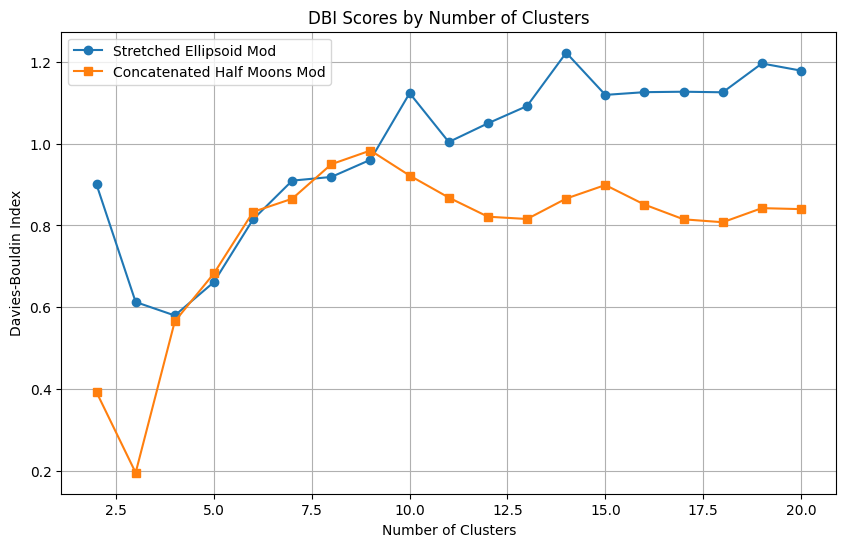

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

# Define the range of clusters to test
clusters_range = range(2, 21)

# Initialize lists to store DBI scores for each dataset
dbi_scores_stretched = []
dbi_scores_concat = []

for n_clusters in clusters_range:
    # KMeans for Stretched Ellipsoids
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(stretched_train_mod)  # Fit on the training set
    kmeans_labels_stretched = kmeans.predict(stretched_val_mod)  # Predict labels for the validation set
    dbi_stretched = davies_bouldin_score(stretched_val_mod, kmeans_labels_stretched)  # Calculate DBI on the validation set
    dbi_scores_stretched.append(dbi_stretched)

    # KMeans for Concatenated Half-Moons
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(concat_moons_train_mod)  # Fit on the training set
    kmeans_labels_concat = kmeans.predict(concat_moons_val_mod)  # Predict labels for the validation set
    dbi_concat = davies_bouldin_score(concat_moons_val_mod, kmeans_labels_concat)  # Calculate DBI on the validation set
    dbi_scores_concat.append(dbi_concat)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(clusters_range, dbi_scores_stretched, marker='o', linestyle='-', label='Stretched Ellipsoid Mod')
plt.plot(clusters_range, dbi_scores_concat, marker='s', linestyle='-', label='Concatenated Half Moons Mod')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('DBI Scores by Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
kmeans_stretched = KMeans(n_clusters=18, random_state=42)
kmeans_stretched.fit(stretched_train_mod)
kmeans_labels_stretched_val = kmeans_stretched.predict(stretched_val_mod)

kmeans_concat = KMeans(n_clusters=9, random_state=42)
kmeans_concat.fit(concat_moons_train_mod)
kmeans_labels_concat_val = kmeans_concat.predict(concat_moons_val_mod)

db_index_stretched = davies_bouldin_score(stretched_val_mod, kmeans_labels_stretched_val)
db_index_concat = davies_bouldin_score(concat_moons_val_mod, kmeans_labels_concat_val)

print("Validation DBI for Stretched Ellipsoids:", db_index_stretched)
print("Validation DBI for Concatenated Half-Moons:", db_index_concat)

Validation DBI for Stretched Ellipsoids: 1.1252443667348802
Validation DBI for Concatenated Half-Moons: 0.9829908043698189


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


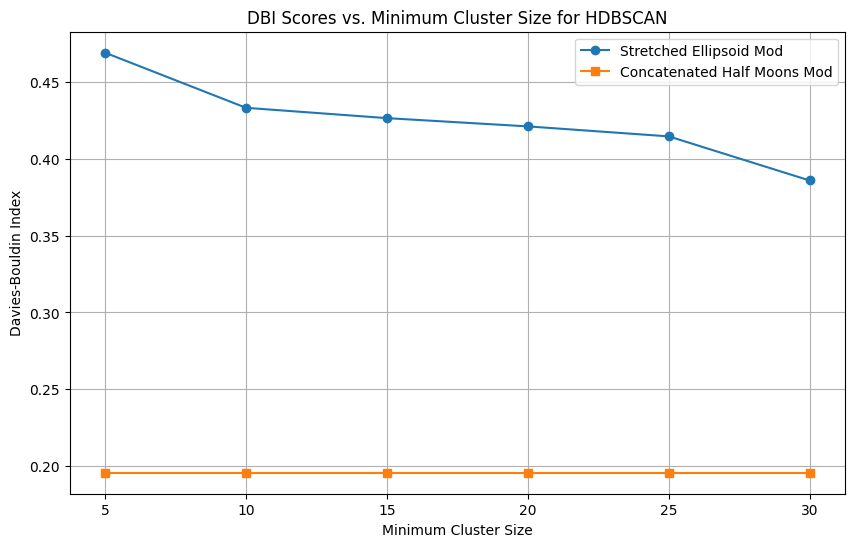

In [34]:
# Function to calculate DBI, excluding noise
def calculate_dbi_hdbscan(X, labels):
    filtered_labels = labels[labels != -1]
    filtered_X = X[labels != -1]
    if len(set(filtered_labels)) > 1:
        return davies_bouldin_score(filtered_X, filtered_labels)
    else:
        return None

min_cluster_sizes = range(5, 31, 5)

dbi_scores_stretched = []
dbi_scores_concat = []

for size in min_cluster_sizes:
    # HDBSCAN for Stretched Ellipsoids
    clusterer_stretched = hdbscan.HDBSCAN(min_cluster_size=size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
    clusterer_stretched.fit(stretched_val_mod)
    dbi_stretched = calculate_dbi_hdbscan(stretched_val_mod, clusterer_stretched.labels_)
    dbi_scores_stretched.append(dbi_stretched if dbi_stretched is not None else np.nan)

    # HDBSCAN for Concatenated Half-Moons
    clusterer_concat = hdbscan.HDBSCAN(min_cluster_size=size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
    clusterer_concat.fit(concat_moons_val_mod)
    dbi_concat = calculate_dbi_hdbscan(concat_moons_val_mod, clusterer_concat.labels_)
    dbi_scores_concat.append(dbi_concat if dbi_concat is not None else np.nan)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(min_cluster_sizes, dbi_scores_stretched, marker='o', linestyle='-', label='Stretched Ellipsoid Mod')
plt.plot(min_cluster_sizes, dbi_scores_concat, marker='s', linestyle='-', label='Concatenated Half Moons Mod')
plt.xlabel('Minimum Cluster Size')
plt.ylabel('Davies-Bouldin Index')
plt.title('DBI Scores vs. Minimum Cluster Size for HDBSCAN')
plt.legend()
plt.grid(True)
plt.show()


In [35]:
# Function to calculate DBI, excluding noise
def calculate_dbi_hdbscan(X, labels):
    # Filter out noise points
    filtered_labels = labels[labels != -1]
    filtered_X = X[labels != -1]

    # Ensure there is more than one cluster left after filtering out noise
    if len(set(filtered_labels)) > 1:
        return davies_bouldin_score(filtered_X, filtered_labels)
    else:
        return None

dbi_stretched_val_hdbscan = calculate_dbi_hdbscan(stretched_val_mod, y_pred_stretched_val_hdbscan)
dbi_concat_moons_val_hdbscan = calculate_dbi_hdbscan(concat_moons_val_mod, y_pred_concat_moons_val_hdbscan)

print("HDBSCAN DBI for Stretched Ellipsoids Validation Set (excluding noise):", dbi_stretched_val_hdbscan)
print("HDBSCAN DBI for Concatenated Half-Moons Validation Set (excluding noise):", dbi_concat_moons_val_hdbscan)


HDBSCAN DBI for Stretched Ellipsoids Validation Set (excluding noise): 0.44391290996543387
HDBSCAN DBI for Concatenated Half-Moons Validation Set (excluding noise): 0.19577303950970182


## Applying Jaccard Index

### What is the Jaccard Index?
The Jaccard Index is a similarity coefficient that quantifies the overlap between sets. In the context of clustering, it provides a robust measure to compare an algorithm's results to predefined labels (ground truth) or against another clustering outcome. It is calculated as the size of the intersection between two sets divided by the size of their union:

$$J(A,B) = \frac{|A \cap B|}{|A \cup B|}$$

Where A and B represent the sets being compared (e.g., a cluster found by K-means and a ground truth cluster).

### Why use the Jaccard Index on your stretched ellipsoid dataset?

The Jaccard Index provides a valuable quantitative tool for assessing how well the clusters generated by K-means align with the underlying structure present in my synthetic dataset. A higher Jaccard Index score indicates better agreement between the K-means clusters and the actual categories within the data (the 'ground truth'). This allows me to gauge the effectiveness of the K-means algorithm in uncovering the true structure of my data.

Since I have a synthetic dataset, I possess the advantage of knowing the true class labels for each data point. By calculating the Jaccard Index, I can validate the K-means algorithm's ability to recover these pre-defined groups. This controlled environment serves as a valuable testing ground for the algorithm.

The Jaccard Index can also be used to systematically compare the performance of different clustering algorithms on my specific dataset. For instance, I can compare K-means with hierarchical clustering. The algorithm that yields a higher Jaccard Index is likely better suited to the structure of the data in my dataset.

In [36]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score

n_samples = 1000
random_state = 42
X_stretched_mod, y_stretched_mod = make_blobs(
    n_samples=n_samples, centers=6, n_features=3,
    cluster_std=[5.0, 3.0, 0.5, 2.7, 2.0, 1.5], random_state=random_state)

X_stretched_mod[:, 1] *= 2  # Stretching along the y-axis
X_stretched_mod[:, 2] *= 3  # Stretching along the z-axis

# K-means clustering
kmeans = KMeans(n_clusters=6, random_state=random_state)
kmeans.fit(X_stretched_mod)
kmeans_labels = kmeans.labels_

# Calculate the Jaccard Index
def labels_to_binary(labels, cluster_label):
    return (labels == cluster_label).astype(int)

# Compute Jaccard Index for each cluster
jaccard_indices = []
for cluster_label in np.unique(kmeans_labels):
    pred_binary = labels_to_binary(kmeans_labels, cluster_label)
    for true_label in np.unique(y_stretched_mod):
        truth_binary = labels_to_binary(y_stretched_mod, true_label)
        index = jaccard_score(truth_binary, pred_binary)
        jaccard_indices.append((cluster_label, true_label, index))

# Display the Jaccard indices
for label_pair in jaccard_indices:
    print(f"Jaccard Index for K-means Cluster {label_pair[0]} and Ground Truth Cluster {label_pair[1]}: {label_pair[2]:.2f}")


Jaccard Index for K-means Cluster 0 and Ground Truth Cluster 0: 0.00
Jaccard Index for K-means Cluster 0 and Ground Truth Cluster 1: 0.00
Jaccard Index for K-means Cluster 0 and Ground Truth Cluster 2: 0.00
Jaccard Index for K-means Cluster 0 and Ground Truth Cluster 3: 0.98
Jaccard Index for K-means Cluster 0 and Ground Truth Cluster 4: 0.00
Jaccard Index for K-means Cluster 0 and Ground Truth Cluster 5: 0.00
Jaccard Index for K-means Cluster 1 and Ground Truth Cluster 0: 0.02
Jaccard Index for K-means Cluster 1 and Ground Truth Cluster 1: 0.02
Jaccard Index for K-means Cluster 1 and Ground Truth Cluster 2: 0.00
Jaccard Index for K-means Cluster 1 and Ground Truth Cluster 3: 0.01
Jaccard Index for K-means Cluster 1 and Ground Truth Cluster 4: 0.01
Jaccard Index for K-means Cluster 1 and Ground Truth Cluster 5: 0.89
Jaccard Index for K-means Cluster 2 and Ground Truth Cluster 0: 0.00
Jaccard Index for K-means Cluster 2 and Ground Truth Cluster 1: 0.34
Jaccard Index for K-means Cluster 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The output provides Jaccard Index values to show how closely the clusters identified by the K-means algorithm match the established 'ground truth' clusters. The Jaccard Index measures the similarity between sets. In this context, it demonstrates the degree of overlap between each K-means cluster and the corresponding ground truth cluster. The index ranges from 0 to 1:

- A score of 0 indicates no overlap between a K-means cluster and a ground truth cluster (they have no common members).
- A score of 1 indicates perfect overlap (all members of the K-means cluster are also within the ground truth cluster, and vice versa)."

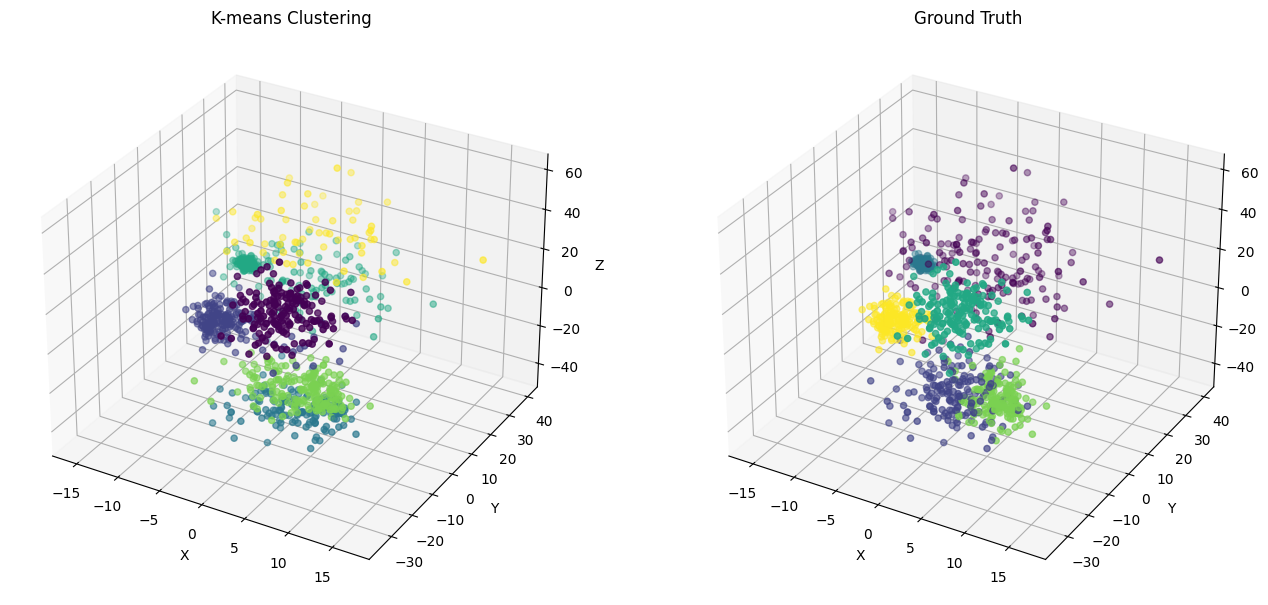

In [37]:
# Create a 3D plot
fig = plt.figure(figsize=(16, 8))

# Plot K-means clustering results
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X_stretched_mod[:, 0], X_stretched_mod[:, 1], X_stretched_mod[:, 2], c=kmeans_labels, cmap='viridis', marker='o')
ax.set_title('K-means Clustering')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Plot Ground Truth
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_stretched_mod[:, 0], X_stretched_mod[:, 1], X_stretched_mod[:, 2], c=y_stretched_mod, cmap='viridis', marker='o')
ax2.set_title('Ground Truth')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# Show plot
plt.show()

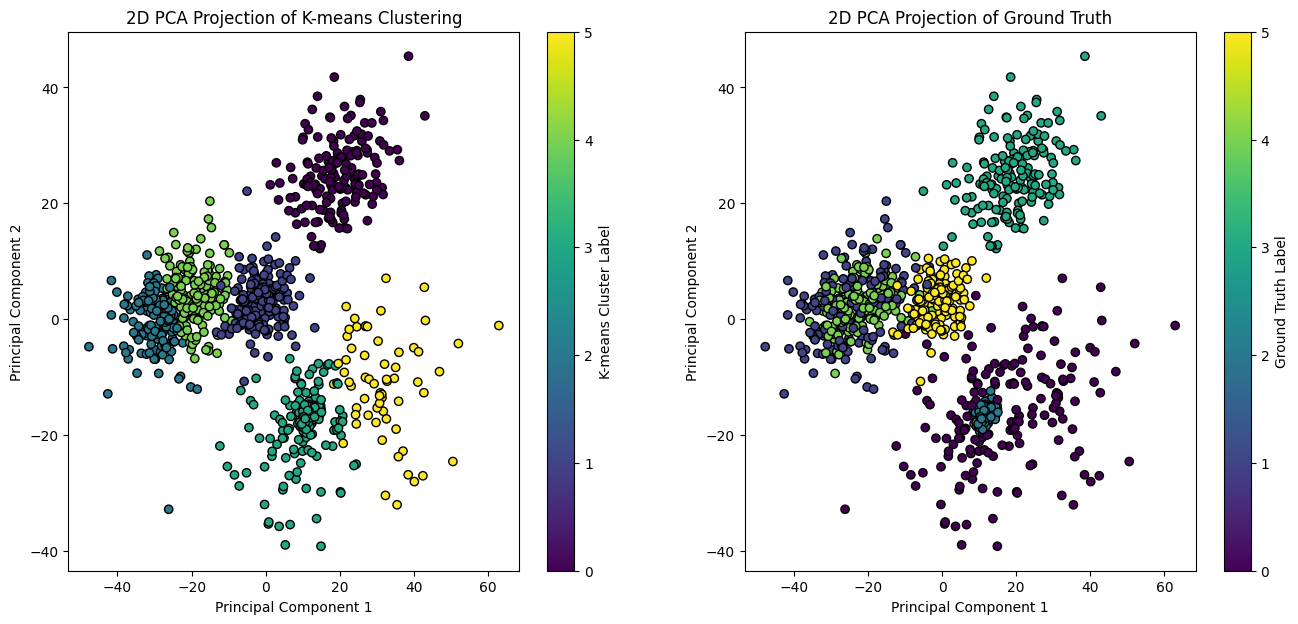

In [38]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_stretched_mod)

# K-means labels plot
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', marker='o', edgecolor='k')
plt.title('2D PCA Projection of K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='K-means Cluster Label')

# Ground truth plot
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_stretched_mod, cmap='viridis', marker='o', edgecolor='k')
plt.title('2D PCA Projection of Ground Truth')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Ground Truth Label')

plt.show()


Explanation:

- Left Plot (K-means Clustering): Visualizes the clusters produced by the K-means algorithm. Data points belonging to the same cluster share the same color.
- Right Plot (Ground Truth): Displays the dataset's true class labels (the 'ground truth'). Each distinct class is represented by a unique color."